In [2]:
import getpass
import os
import dill
from dotenv import load_dotenv
from kiwipiepy import Kiwi
from pinecone import Pinecone
from langchain_openai import OpenAIEmbeddings
from langchain_pinecone import PineconeVectorStore
from langchain.retrievers import EnsembleRetriever
from sentence_transformers import SentenceTransformer
import cohere

load_dotenv()

# print("질문 환경 설정 중...")

# api 설정
pinecone_api = os.environ["PINECONE_API_KEY"]
cohere_api = os.environ["COHERE_API_KEY"]


# vectorstore load
pc = Pinecone(api_key=pinecone_api)
index_name = "canon"
index = pc.Index(index_name)
embeddings = OpenAIEmbeddings(model="text-embedding-3-small")
vector_store = PineconeVectorStore(embedding=embeddings, index=index)

# retriever load
retriever = vector_store.as_retriever(
  search_type="similarity", search_kwargs={"k": 10},
)

kiwi = Kiwi()

def kiwi_tokenize(text):
    return [token.form for token in kiwi.tokenize(text)]

with open("data/bm25_retriever_r50.pkl", "rb") as f:
    bm25_retriever = dill.load(f)
bm25_retriever.preprocess_func = kiwi_tokenize

ensemble_retriever = EnsembleRetriever(
    retrievers=[retriever, bm25_retriever],
    weights=[0.5, 0.5]  # Dense와 BM25 각각 50% 가중치
)

# reranker load
cohere_client = cohere.Client(cohere_api)

# # filter model load
local_model_path = "../../Study_RAG/RAG/subgraph/models/ko-sbert-sts"  # 저장할 로컬 경로

filter_embedding_model = SentenceTransformer(local_model_path)

# from konlpy.tag import Okt
# from rank_bm25 import BM25Okapi

# # Okt (Twitter) 토크나이저 초기화
# okt = Okt()

# def okt_tokenize(text):
#     return okt.morphs(text)  # 형태소 단위로 분할


In [20]:
from sentence_transformers import SentenceTransformer

# 모델 경로 설정
model_name = "jhgan/ko-sbert-sts"  # 한국어 SBERT 임베딩 모델
local_model_path = "./models/ko-sbert-sts"  # 저장할 로컬 경로

# 모델 다운로드 및 로컬 저장
model = SentenceTransformer(model_name)
model.save(local_model_path)

print(f"모델이 로컬 경로 '{local_model_path}'에 저장되었습니다.")

모델이 로컬 경로 './models/ko-sbert-sts'에 저장되었습니다.


In [3]:
from dotenv import load_dotenv
from typing import Annotated, TypedDict, List, Any, Dict
from langchain_core.output_parsers import BaseOutputParser, StrOutputParser
from langchain_core.prompts import PromptTemplate
from langchain_openai import ChatOpenAI
from langchain_core.messages import AIMessage
from pydantic import BaseModel, Field
import json
import operator
import numpy as np

from langgraph.types import Send

# from ingestion import ensemble_retriever, filter_embedding_model, cohere_client


# GraphState 상태 정의
class CanonState(TypedDict):
    question: Annotated[str, "Question"] # parentgraph 와 공유
    transform_question: Annotated[list, "Transformed queries generated by LLM"]
    multi_context: Annotated[list[str], operator.add]
    ensemble_context: Annotated[str, "Ensemble_context"]
    filtered_context: Annotated[str, "Filtering Context"]
    rerank_context : Annotated[str, "Context"]
    answer: Annotated[str, "Answer"] # parentgraph 로 전송

class Queries(BaseModel):
    queries: list[str]

class Document(BaseModel):
    retreive_document: str

class AllDocument(BaseModel):
    docuemnt: str

class QueryState(TypedDict):
    query: str

# multiquery Node

load_dotenv()

# output 정의
class LineListOutputParser(BaseOutputParser[List[str]]):
    def parse(self, text: str) -> List[str]:
        if isinstance(text, AIMessage):
            text = text.content
        try:
            parsed_json = json.loads(text)
            return parsed_json
        except:
            lines = text.strip().split("\n")
            return list(filter(None, lines))

def query_chain(question):
    output_parser = LineListOutputParser()
    QUERY_PROMPT = PromptTemplate(
        input_variables=["question"],
        template="""You are an AI language model assistant. Your task is to generate five 
        different versions of the given user question to retrieve relevant documents from a vector 
        database. By generating multiple perspectives on the user question, your goal is to help
        the user overcome some of the limitations of the distance-based similarity search. 
        Provide these alternative questions in a JSON array format, separated by commas.
        Do not include any additional explanations.
        Original question: {question}
        Output format: ["question1", "question2", "question3", "question4", "question5"]""",
    )
    llm = ChatOpenAI(temperature=0, model="gpt-4o-mini")

    llm_chain = QUERY_PROMPT | llm | output_parser
    queries = llm_chain.invoke({"question":question})
    return queries

def query_expansion(state: CanonState) -> CanonState:
    print("---[CANON] QUERY GENERTATE---")
    query = state["question"]
    transformed_queries = query_chain(query)
    return {"question":query, "transform_question": transformed_queries}


# ensemble Retriever + Map reduce
def ensemble_document(state: QueryState):
    print("---[CANON] ENSEMBLE RETRIEVE---")
    questions = state["question"]
    print(f"질문 : {questions}")
    documents = ensemble_retriever.invoke(questions)
    # print(documents)
    return {"multi_context": documents}

def document_search(state: CanonState):
    return [Send("ensemble_retriever", {"question": q}) for q in state["transform_question"]]

def duplicated_delete(state: CanonState):
    documents = state['multi_context']
    seen_ids = set()
    merge_results = []
    for item in documents:
        if item.id not in seen_ids:
            merge_results.append(item)
            seen_ids.add(item.id)
    return {"ensemble_context": merge_results}

# document filter
def filter_documents_by_percentile(docs_with_scores, percentile_cutoff=80):
    scores = [score for _, score in docs_with_scores]
    if not scores:
        return []
    cutoff_value = np.percentile(scores, percentile_cutoff)  # 상위 percentile 계산
    return [doc for doc, score in docs_with_scores if score >= cutoff_value]

def assign_embedding_similarity_score(docs, query_embedding):
    doc_embeddings = [filter_embedding_model.encode(doc.page_content) for doc in docs]
    scores = [np.dot(query_embedding, doc_embedding) for doc_embedding in doc_embeddings]
    return list(zip(docs, scores))

def filter_document(state: CanonState) -> CanonState:
    print("---DOCUMENT FILTERING---")
    # Query 및 문서 임베딩 생성
    query = state['question']
    docs = state['ensemble_context']
    query_embedding = filter_embedding_model.encode(query)
    docs_with_scores = assign_embedding_similarity_score(docs, query_embedding)
    filtered_docs = filter_documents_by_percentile(docs_with_scores, percentile_cutoff=80)
    print(f"필터링 전 문서 : {len(docs)} / 필터링 후 문서 : {len(filtered_docs)}")
    return {"filtered_context": filtered_docs}

# reranker
def rerank_with_cohere(query, retrieved_docs, top_n=5):
    documents = [doc.page_content for doc in retrieved_docs]
    response = cohere_client.rerank(
        query=query,
        documents=documents,
        top_n=top_n,
        model="rerank-v3.5"
    )
    reranked_docs = [retrieved_docs[result.index] for result in response.results]
    return reranked_docs

# Reranker Node
def rerank_docs(state: CanonState) -> CanonState:
    print("---[CANON] RERANK---")
    questions = state['question']
    documents = state['filtered_context']
    reranked_docs = rerank_with_cohere(questions, documents)
    print(reranked_docs)
    return {"rerank_context": reranked_docs}

# Generate Node
def generate_chain(context, question):
    llm = ChatOpenAI(temperature=0, model="gpt-4o-mini")
    ANSWER_PROMPT = PromptTemplate(
        input_variables=["question","context"],
        template="""
    당신은 카메라 사용자 메뉴얼에 대한 정보를 제공하는 AI 어시스턴트입니다. 사용자가 질문을 하면, 제공된 Document 형식의 context를 활용하여 답변을 생성하세요. 각 Document에는 이미지 경로가 포함된 metadata가 있습니다. 답변을 생성할 때, 관련된 이미지가 있는 경우 [image: metadata 내 이미지 경로] 형식으로 답변에 포함시켜 주세요. 

    예시:
    사용자 질문: "카메라의 ISO 설정 방법을 알려주세요."
    답변: "카메라의 ISO 설정은 메뉴에서 '설정'을 선택한 후 'ISO' 옵션을 선택하여 조정할 수 있습니다. [image: /path/to/iso_setting_image]"

    이와 같은 형식으로 질문에 대한 답변을 생성하세요.

    컨텍스트와 질문을 기반으로 답변을 생성하세요:
    - 컨텍스트: {context}
    - 질문: {question}
    """
    )
    generation_chain = ANSWER_PROMPT | llm | StrOutputParser()
    answer = generation_chain.invoke({"context":context,"question":question})
    return answer

def generate(state: CanonState):
    print("---[CANON] GENERATE---")
    question = state["question"]
    context = state["rerank_context"]
    result = generate_chain(context, question)
    
    return {"question": question, "answer": result}

In [4]:
# from cononNode import query_expansion, ensemble_document, duplicated_delete, document_search
# from cononNode import filter_document, rerank_docs, generate
# from cononNode import CanonState

from langgraph.graph import START, END, StateGraph


canongraph = StateGraph(CanonState)
canongraph.add_node("query_expansion", query_expansion)
canongraph.add_node("ensemble_retriever", ensemble_document)
canongraph.add_node("merge_document", duplicated_delete)
canongraph.add_node("filter", filter_document)
canongraph.add_node("reranker", rerank_docs)
canongraph.add_node("generate", generate)

canongraph.add_edge(START, "query_expansion")
canongraph.add_conditional_edges("query_expansion", document_search, ["ensemble_retriever"])
canongraph.add_edge("ensemble_retriever", "merge_document")
# canongraph.add_edge("merge_document", "reranker")

canongraph.add_edge("merge_document", "filter")
canongraph.add_edge("filter", "reranker")
canongraph.add_edge("reranker", "generate")
canongraph.add_edge("generate", END)

subgraph_canon = canongraph.compile()

In [27]:

for s in subgraph_canon.stream({"question": "iso 설정에 대해 알려줘"}):
    print(s)

---[CANON] QUERY GENERTATE---
{'query_expansion': {'question': 'iso 설정에 대해 알려줘', 'transform_question': ['iso 설정 방법을 설명해줘', 'iso 설정에 대한 정보를 제공해줘', 'iso 설정의 중요성에 대해 알려줘', 'iso 설정을 어떻게 해야 하는지 궁금해', 'iso 설정 관련 자료를 찾고 있어']}}
---[CANON] ENSEMBLE RETRIEVE---
질문 : iso 설정 방법을 설명해줘
---[CANON] ENSEMBLE RETRIEVE---
질문 : iso 설정에 대한 정보를 제공해줘
---[CANON] ENSEMBLE RETRIEVE---
질문 : iso 설정의 중요성에 대해 알려줘
---[CANON] ENSEMBLE RETRIEVE---
질문 : iso 설정을 어떻게 해야 하는지 궁금해
---[CANON] ENSEMBLE RETRIEVE---
질문 : iso 설정 관련 자료를 찾고 있어
{'ensemble_retriever': {'multi_context': [Document(id='chunk-r50-680', metadata={'brand': 'Canon', 'image_path': ['/Users/yoeun/Library/Mobile Documents/com~apple~CloudDocs/github/FINAL Project/parse&chunk/data/image/r50/r50_page_664_1.png', '/Users/yoeun/Library/Mobile Documents/com~apple~CloudDocs/github/FINAL Project/parse&chunk/data/image/r50/r50_page_664_2.png'], 'index': '탭 메뉴: 설정', 'main_index': '설정', 'model': 'R50', 'page': 664.0, 'pdf_path': '/Users/yoeun/Library/Mobile Documents/co

In [5]:
from typing_extensions import TypedDict, Annotated
from typing import Optional, Dict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate
from langchain_openai import ChatOpenAI


# class RequiredInputState(TypedDict):

# class OptionalInputState(TypedDict, total=False):


class InputState(TypedDict):
    """ 필수 필드와 선택적 필드를 분리하여 `question`만 필수로 유지 """
    question: str  # 필수 필드
    brand: Annotated[Optional[str], "brandname"]  # 선택적 필드
    model: Annotated[Optional[str], "modelname"]  # 선택적 필드


class OutputState(TypedDict):
    message: Annotated[list, add_messages]
    answer: Annotated[str, "Answer"]
    keyword: Annotated[list, "keywordExtract"]
    suggest_question: Annotated[list, "suggestquestion"]
    
# 전체 state
class OverallState(TypedDict):
    question: Annotated[str, "Question"]
    ex_question: Annotated[str, "issettingbeforequstion"]
    brand: Annotated[Optional[str],"brandname"]
    model: Annotated[Optional[str],"modelname"]
    message: Annotated[list, add_messages]
    answer: Annotated[str, "Answer"]
    keyword: Annotated[list, "keywordExtract"]
    suggest_question: Annotated[list, "suggestquestion"]
    next_step: Annotated[str, "routerstep"]
    validation_results: Dict[str, bool]  

# hidden state
class RouterState(TypedDict):
    question: Annotated[str, "Question"]
    brand: Annotated[Optional[str],"brandname"]
    model: Annotated[Optional[str],"modelname"]
    new_queries: list
    awaiting_user_input: Annotated[bool, "사용자 입력 대기 상태"]
    question_context: Annotated[Dict, "질문 컨텍스트 저장"]  # 새로 추가

In [6]:
## router 관련 함수
from langchain_core.output_parsers import StrOutputParser
from langchain_core.messages import AIMessage
from langchain_core.runnables import RunnableLambda
from langchain_core.prompts import ChatPromptTemplate


import json

# output 정의
def parse_validation_results(text: str) -> Dict[str, bool]:
    """ LLM 응답을 리스트로 변환 후 Dict로 매핑 """
    try:
        parsed_json = json.loads(text)  # JSON 형식이면 바로 변환
    except:
        parsed_json = list(filter(None, text.replace("[","").replace("]","").strip().split(",")))  # 개행 문자 기준으로 분리 후 빈 값 제거

    return {
        "camera_question": parsed_json[0] == "TRUE",
        "is_setting": parsed_json[1] == "TRUE",
        "choose_brand": parsed_json[2] == "TRUE"
    }

parse_lambda = RunnableLambda(parse_validation_results)  # LCEL에서 Lambda로 실행


# 검증 기준 체크하는 함수
def check_validation_criteria(state: InputState) -> RouterState:
    print("---QUERY CLASSIFIER---")
    question = state['question']
    brand = state.get('brand', None)  # 선택적 필드는 `.get()` 사용
    model = state.get('model', None)  # 선택적 필드

    llm = ChatOpenAI(model="gpt-4o", temperature=0)
    
    # 검증 템플릿
    validation_prompt = ChatPromptTemplate.from_template("""
    다음은 사용자의 질문과 선택한 브랜드 및 모델 정보입니다. 이 정보를 바탕으로 세 가지 사항을 판단하세요. 각 판단은 TRUE 또는 FALSE로 리스트 형태로 반환합니다.

    1. 사용자의 질문이 카메라에 대한 질문인지 판단하세요.
    2. 사용자의 질문에 카메라 사용자 메뉴얼에 대한 내용이 포함되어 있는지 판단하세요.(카메라 설정, 기능, 안전 유의사항 등)
    3. 제공된 정보에 브랜드와 모델이 포함되어 있는지, 사용자가 선택한 내용과 질문 모두에서 확인하세요.

    사용자 질문: {question}
    선택한 브랜드: {brand}
    선택한 모델: {model}

    판단 결과를 [TRUE, FALSE, FALSE] 형식으로 반환하세요.
    """)

    # LCEL 기반 실행 체인
    llm_chain = (
        validation_prompt | llm | StrOutputParser() | parse_lambda  # Dict[str, bool] 형태로 변환
    )
    
    # 검증 실행
    validation_results = llm_chain.invoke({"question": question, "brand": brand, "model": model})
    print("검증 결과")
    print(validation_results)
    return {**state, "validation_results" : validation_results}

# 조건에 따른 다음 단계 결정
def decide_next_step(state: RouterState) -> RouterState:
    print("---CHECK NEXT STEP---")
    brand = state.get('brand', None)
    validation_results = state["validation_results"]
    
    if brand == 'canon':
        next_step = "rag_canon" # subgraph
        
        # elif brand == 'sony':
        #     next_step = "rag_sony" # subgraph
        # elif brand == 'fuji':
        #     next_step = "rag_fuji" # subgraph

    else:
        # if not validation_results["camera_question"]:
        #     next_step = "not_for_camera" # 카메라 관련 질문이 아니다 답변 노드
        # elif not validation_results["choose_brand"]:
        #     next_step = "ask_brand" # 역질문 노드
        # elif not validation_results["is_setting"]:
        #     next_step = "settings_generate" # 사용자 메뉴얼 관련 답변 및 질문 재생성 노드
        next_step = "rag_any"
    
    return {
        **state,
        "next_step": next_step
    }

In [7]:
def generate_all_chain(question):
    llm = ChatOpenAI(temperature=0, model="gpt-4o-mini")
    ANSWER_PROMPT = PromptTemplate(
        input_variables=["question","context"],
        template="""
    당신은 카메라에 대한 정보를 제공하는 AI 어시스턴트입니다. 사용자가 질문을 하면, 답변을 생성하세요. 

    예시:
    사용자 질문: "카메라의 ISO 설정 방법을 알려주세요."
    답변: "카메라의 ISO 설정은 메뉴에서 '설정'을 선택한 후 'ISO' 옵션을 선택하여 조정할 수 있습니다. 

    이와 같은 형식으로 질문에 대한 답변을 생성하세요.

    질문을 기반으로 답변을 생성하세요:
    - 질문: {question}
    """
    )
    generation_chain = ANSWER_PROMPT | llm | StrOutputParser()
    answer = generation_chain.invoke({"question":question})
    return answer

def generate_all(state: OverallState):
    print("---GENERATE---")
    question = state["question"]

    # context = state["rerank_context"]
    result = generate_all_chain(question)
    
    return {"question": question, "answer": result}

In [8]:
from langgraph.graph import StateGraph
from langchain_core.runnables import RunnableLambda
from langgraph.checkpoint.memory import MemorySaver

# 그래프 초기화
graph = StateGraph(OverallState, input=InputState)

# 노드 추가
graph.add_node("validate_input", RunnableLambda(check_validation_criteria))
graph.add_node("decide_next_step", RunnableLambda(decide_next_step))
# graph.add_node("ask_brand", RunnableLambda(refine_question))
graph.add_node("rag_any", generate_all)
graph.add_node("rag_canon", subgraph_canon)

def conditional_routing(state):
    if state["next_step"] == "rag_any":
        return "rag_any"
    elif state["next_step"] == "rag_canon":
        return "rag_canon"
    else:
        return "END"
# 엣지 추가
graph.add_edge(START, 'validate_input')
graph.add_edge("validate_input", "decide_next_step")
graph.add_conditional_edges("decide_next_step", conditional_routing)

graph.add_edge("rag_any", END)
graph.add_edge("rag_canon",END)

memory=MemorySaver()

app=graph.compile(checkpointer=memory)

In [9]:
app.get_graph().draw_mermaid_png(output_file_path='./graph_node_route.png')

b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x01#\x00\x00\x01\xb0\x08\x02\x00\x00\x00m\xb0\x94\x97\x00\x00\x00\x01sRGB\x00\xae\xce\x1c\xe9\x00\x00 \x00IDATx\x9c\xed\xddg@Sg\xdb\x07\xf0;\x93\x84@\x18\t\x1bY\x82\x02.PT\x04\xd4\x8a\x03\x05\\\xad[\x9f\x0ek\xd5Vk\x9d\xd5V\xacU\xab\xd5V\xadU\xd1\xb6R\xc5:\xda\xaa\xad\x8b\xaa8P\x14p\xe3d\xa8 \xc8&\x04\x08!\x90\x9d\xbc\x1f\xd2\x87\x97G\x93\x90@\x92s\x12\xae\xdf\'8\xf3\n\x87\x7f\xce\xbeo\x82R\xa9D\x00\x00##b]\x00\x00\x9d\x02$\r\x00S\x80\xa4\x01`\n\x904\x00L\x01\x92\x06\x80)@\xd2\x000\x052\xd6\x05\x00\xd3\xa9*\x165\xf1\xe5M\r2\x85\\)\x16*\xb0.G\'V4"\xd5\x9a\xc8`\x92m\xec\xc8,w*\xd6\xe5\xb4\x1f\x01\xee\xa7Y8%\xca\xbd\xc3/z\xd2T\x94\xd3\xe4\x1dhM\xa2\x12\x18L\xb2\x833U,\x94c]\x99N\x08DB\x03W\xda\xcc\x97Y\xd1\x89\x15/E~\xbd\x18~=m=\xbb\xd1\xb0\xaeKo\x904K\xf6\xe0*\xef\xc1\xb5z\xef \x86_O\x86oO\x06\xd6\xe5tTc\xbd\xac\xe8iSM\xb9\xb8\xaeJ\x12\x11\xcf\xf2\xf0\xa7c]\x91\x1e i\x96\xa9\xbc@t>\xb92\xb0\xbfm\xe486\x81\x80u5\x86VU,\xcaJ\xa9\xb5gS\xa2\xa79c]

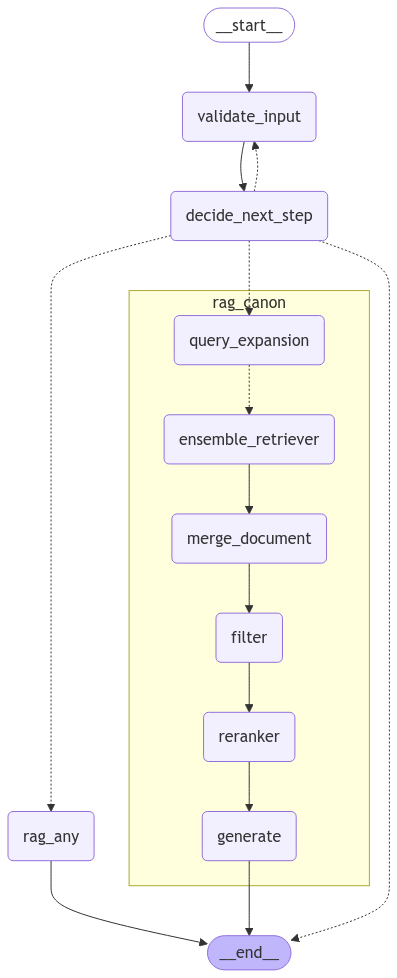

In [11]:
from IPython.display import display, Image

display(Image(app.get_graph(xray=True).draw_mermaid_png()))


In [29]:
thread = {"configurable": {"thread_id": "3"}}

for event in app.stream({"question": "iso 설정에 대해 알려줘", "brand":"canon"}, config=thread, stream_mode="updates", subgraphs=True):
    print(event)
    print("\n")

---QUERY CLASSIFIER---
검증 결과
{'camera_question': True, 'is_setting': False, 'choose_brand': False}
((), {'validate_input': {'question': 'iso 설정에 대해 알려줘', 'brand': 'canon', 'message': [], 'validation_results': {'camera_question': True, 'is_setting': False, 'choose_brand': False}}})


---CHECK NEXT STEP---
((), {'decide_next_step': {'question': 'iso 설정에 대해 알려줘', 'brand': 'canon', 'message': [], 'validation_results': {'camera_question': True, 'is_setting': False, 'choose_brand': False}, 'next_step': 'rag_canon'}})


---[CANON] QUERY GENERTATE---
(('rag_canon:9780e893-9c63-d0bb-3e66-9329b1da0f59',), {'query_expansion': {'question': 'iso 설정에 대해 알려줘', 'transform_question': {'lines': ['iso 설정 방법을 설명해 주세요', 'iso 설정에 대한 정보를 알고 싶어요', 'iso 설정의 중요성에 대해 알려주세요', 'iso 설정을 어떻게 해야 하나요?', 'iso 설정 관련 자료를 찾고 있습니다']}}})---[CANON] ENSEMBLE RETRIEVE---



(('rag_canon:9780e893-9c63-d0bb-3e66-9329b1da0f59',), {'ensemble_retriever': {'multi_context': [Document(id='chunk-r6-590', metadata={'brand': 'Canon', 'im

In [73]:

app.get_state(thread)

StateSnapshot(values={'question': 'iso 설정에 대해 알려줘', 'brand': 'canon', 'message': [], 'answer': '"ISO 설정은 카메라의 감도를 조정하는 중요한 기능입니다. 카메라 메뉴에서 \'설정\'을 선택한 후 \'ISO\' 옵션을 찾아 조정할 수 있습니다. ISO 값을 높이면 어두운 환경에서도 촬영이 가능하지만, 노이즈가 증가할 수 있습니다. 반대로 ISO 값을 낮추면 노이즈는 줄어들지만, 밝은 환경에서만 촬영이 가능합니다. [image: /Users/yoeun/Library/Mobile Documents/com~apple~CloudDocs/github/FINAL Project/parse&chunk/data/pdf/split_pdf_image/m50/m50_page_636.jpg]"', 'next_step': 'rag_canon', 'validation_results': {'camera_question': True, 'is_setting': False, 'choose_brand': False}}, next=(), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1efe431e-8256-6436-8003-85af6be4dff3'}}, metadata={'source': 'loop', 'writes': {'rag_canon': {'question': 'iso 설정에 대해 알려줘', 'answer': '"ISO 설정은 카메라의 감도를 조정하는 중요한 기능입니다. 카메라 메뉴에서 \'설정\'을 선택한 후 \'ISO\' 옵션을 찾아 조정할 수 있습니다. ISO 값을 높이면 어두운 환경에서도 촬영이 가능하지만, 노이즈가 증가할 수 있습니다. 반대로 ISO 값을 낮추면 노이즈는 줄어들지만, 밝은 환경에서만 촬영이 가능합니다. [image: /Users/yoeun/Library/Mobile Documents/com

In [75]:
thread = {"configurable": {"thread_id": "2"}}

for event in app.stream({"question": "iso 설정에 대해 알려줘"}, config=thread, stream_mode="updates", subgraphs=True):
    print(event)
    print("\n")

---QUERY CLASSIFIER---
검증 결과
{'camera_question': True, 'is_setting': False, 'choose_brand': False}
((), {'validate_input': {'question': 'iso 설정에 대해 알려줘', 'message': [], 'validation_results': {'camera_question': True, 'is_setting': False, 'choose_brand': False}}})


---CHECK NEXT STEP---
((), {'decide_next_step': {'question': 'iso 설정에 대해 알려줘', 'message': [], 'validation_results': {'camera_question': True, 'is_setting': False, 'choose_brand': False}, 'next_step': 'rag_any'}})


---GENERATE---
((), {'rag_any': {'question': 'iso 설정에 대해 알려줘', 'answer': '답변: "ISO 설정은 카메라의 감도를 조절하는 중요한 요소입니다. 일반적으로 카메라의 메뉴에서 \'설정\' 또는 \'촬영 설정\'을 선택한 후 \'ISO\' 옵션을 찾아 원하는 값을 선택하면 됩니다. 낮은 ISO 값(예: 100)은 밝은 환경에서 사용하고, 높은 ISO 값(예: 1600 이상)은 어두운 환경에서 노이즈를 감수하고 사용합니다."'}})


